In [31]:
''' Importando bibliotecas'''

from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np 

yf.pdr_override()

In [242]:
''' Extraindo dados do Ibovespa da web (Fonte: Yahoo finance)'''

ibovespa = pdr.DataReader('^BVSP', data_source = 'yahoo')
display(ibovespa)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0
1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0
1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0
1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0
...,...,...,...,...,...,...
2021-05-10,122038.000000,122772.000000,121795.000000,121909.000000,121909.000000,8219100
2021-05-11,121904.000000,122964.000000,120145.000000,122964.000000,122964.000000,7988600
2021-05-12,122964.000000,122964.000000,119458.000000,119710.000000,119710.000000,9405200


Text(0.5, 1.0, 'Série histórica Ibovespa')

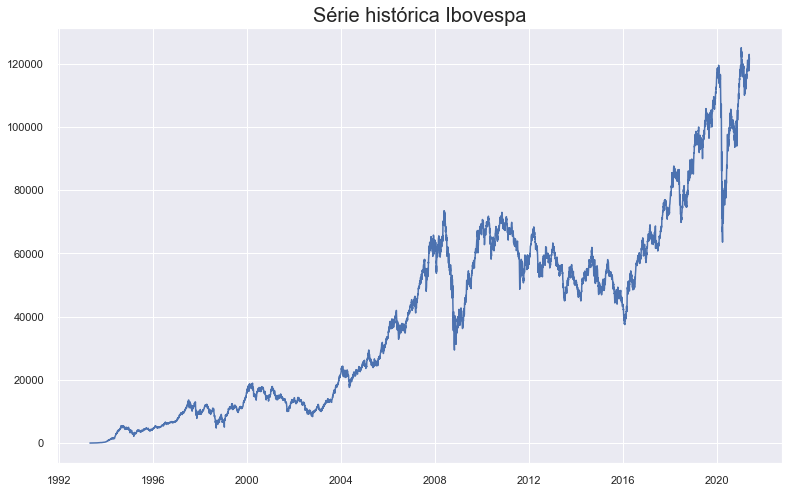

In [272]:
seaborn.set()
plt.figure(figsize = (13,8))
plt.plot(ibovespa['Close'])
plt.title('Série histórica Ibovespa', fontsize = 20)

Aumentando gradativamente o grau de dificuldade, iremos agora explanar o exemplo mais utilizado de correlação de ativos financeiros, o ibovespa e o dólar. 
Os dados serão extráidos pela web do yahoo finance, mas dessa vez será necessário fazer um tratamento dos dados, visto que, em um mesmo período, a quantidade de valores a serem comparados é diferente, pois há dias em que o ibovespa não se movimenta, mas o dólar sim (feriados, por exemplo).
Para fazermos essa comparação, colocaremos os dados do ibovespa e do dólar em um mesmo DataFrame e eliminaremos as linhas onde existirão valores nulos (NaN). 

In [244]:
ibov_dol = ['^BVSP', 'USDBRL=X']
id_df = pdr.get_data_yahoo(ibov_dol, start = '2006-01-01')['Close']
id_df = id_df.dropna()
id_df.columns = ['DÓLAR', 'IBOVESPA']
id_df['IBOV EM DÓLAR'] = id_df['IBOVESPA']/ id_df['DÓLAR']
display(id_df)

[*********************100%***********************]  2 of 2 completed


,DÓLAR,IBOVESPA,IBOV EM DÓLAR
Date,,,
2006-03-24,2.1547,37577.0,17439.550419
2006-03-27,2.1503,37641.0,17504.999091
2006-03-28,2.1677,36682.0,16922.082906
2006-03-29,2.2206,37492.0,16883.725958
2006-03-30,2.1922,37777.0,17232.460971
...,...,...,...
2021-05-10,5.2355,121909.0,23285.073687
2021-05-11,5.2222,122964.0,23546.398445
2021-05-12,5.2212,119710.0,22927.679508


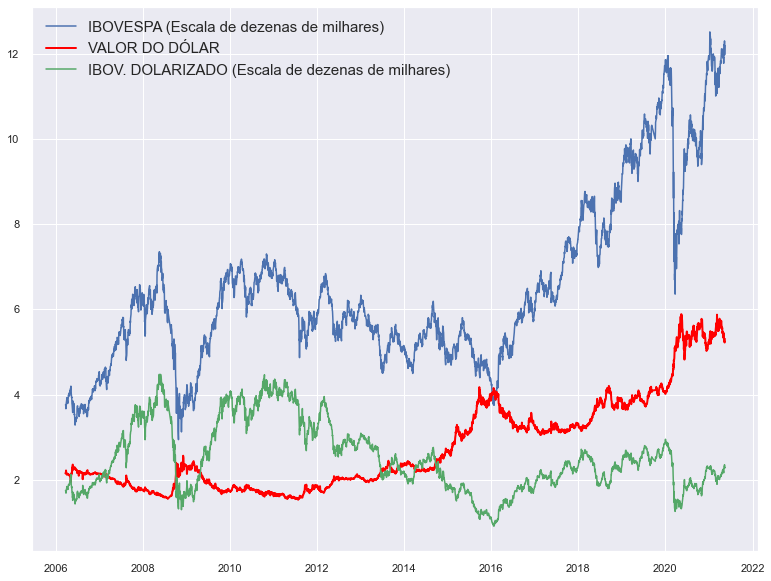

In [279]:
seaborn.set()
plt.figure(figsize = (13, 10))
plt.plot(id_df['IBOVESPA']/10000, label = 'IBOVESPA (Escala de dezenas de milhares)')
plt.plot(id_df.DÓLAR,lw =2, label = 'VALOR DO DÓLAR', c = 'red')
plt.plot(id_df['IBOV EM DÓLAR']/10000 , label = 'IBOV. DOLARIZADO (Escala de dezenas de milhares)', c = 'g')
plt.legend(fontsize = 15)


<AxesSubplot:>

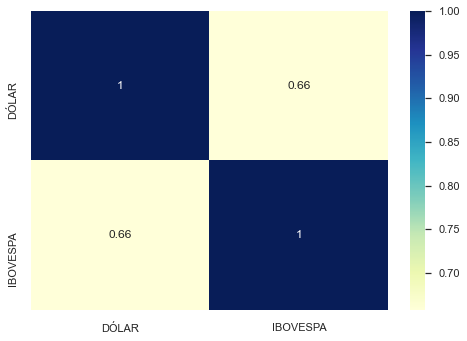

In [246]:
id_df_ = id_df.drop('IBOV EM DÓLAR', axis = 1)
seaborn.heatmap(id_df_.corr(), cmap ='YlGnBu', annot = True)

Agora iremos exibir a variação na correlação entre os dois ativos em forma gráfica, onde será explicitado que houve períodos de correlação positiva e correlação negativa ao longo dos anos.

<AxesSubplot:xlabel='Date'>

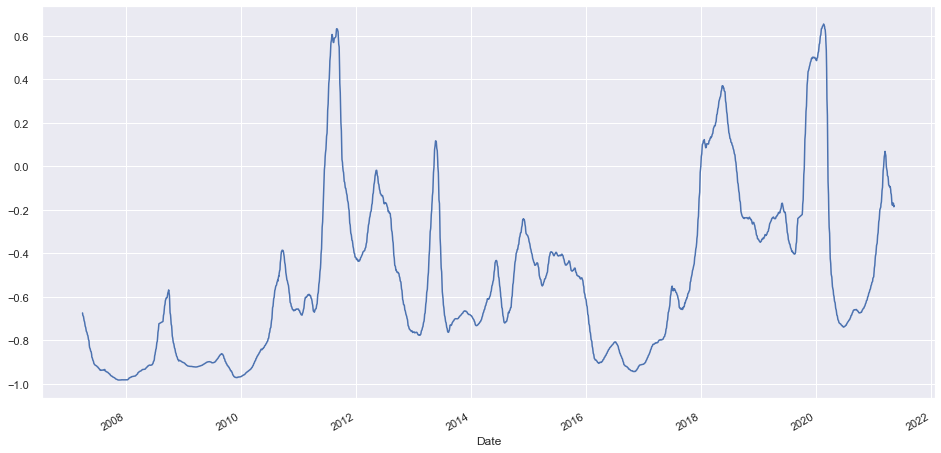

In [247]:
id_df['DÓLAR'].rolling(252).corr(id_df['IBOVESPA']).plot(figsize = (16,8)) # 252 é, aproximadamente,a quantidade dias úteis em um ano

Como podemos observar no gráfico acima, os valores chegaram a ser muito correlacionados negativamente (isto é, próximo a -1,0) durante o ano de 2008 e depois sofreu diversas variações, chegando a ficar positivamente correlacionado, mas nunca passando de 0,6.

Faremos agora um estudo da correlação entre as ações da petrobrás e a cotação do petróleo brent

In [248]:
petrobras_brent = ['PETR4.SA', 'BZ=F']
pp_df = pdr.get_data_yahoo(petrobras_brent)['Close']
pp_df = pp_df.dropna()
pp_df.columns = ['Cotação do petróleo Brent', 'Ações da Petrobrás']
display(pp_df)

[*********************100%***********************]  2 of 2 completed


,Cotação do petróleo Brent,Ações da Petrobrás
Date,,
2007-07-30,75.739998,26.799999
2007-07-31,77.050003,26.370001
2007-08-01,75.349998,26.450001
2007-08-02,75.760002,26.405001
2007-08-03,74.750000,25.200001
...,...,...
2021-05-10,68.320000,24.700001
2021-05-11,68.550003,25.150000
2021-05-12,69.320000,24.780001


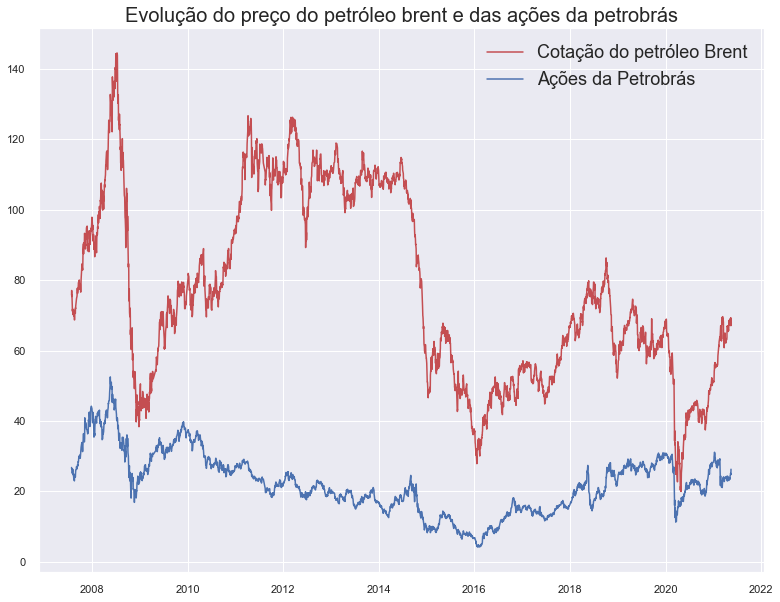

In [249]:
plt.figure(figsize = (13, 10))
plt.title('Evolução do preço do petróleo brent e das ações da petrobrás', fontsize = 20)
plt.plot(pp_df['Cotação do petróleo Brent'], label = 'Cotação do petróleo Brent', c = 'r')
plt.plot(pp_df['Ações da Petrobrás'], label = 'Ações da Petrobrás')
plt.legend(fontsize = 18)

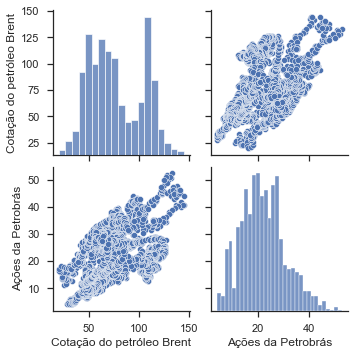

In [277]:
seaborn.set(style = 'ticks')
seaborn.pairplot(pp_df)


<AxesSubplot:>

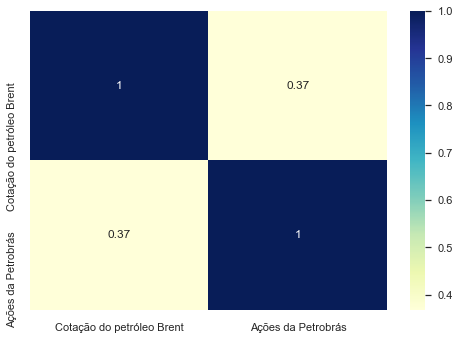

In [251]:
seaborn.heatmap(pp_df.corr(), cmap ='YlGnBu', annot = True)

<AxesSubplot:xlabel='Date'>

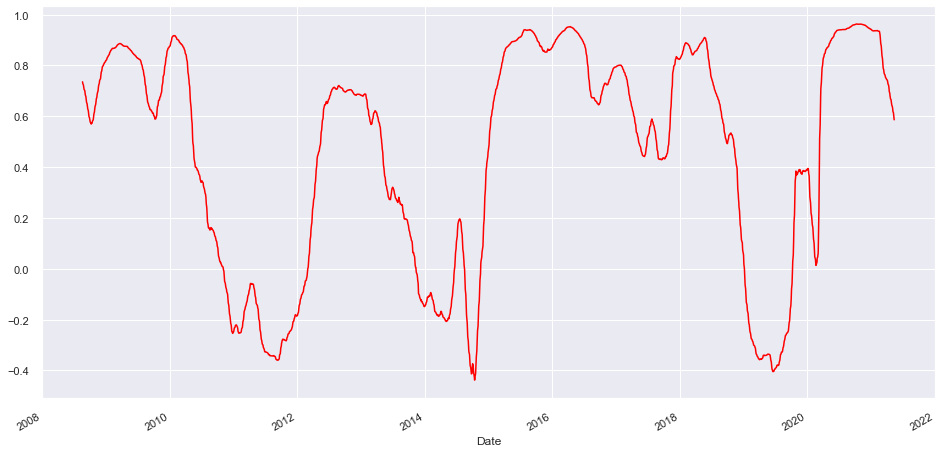

In [276]:
seaborn.set()
pp_df['Ações da Petrobrás'].rolling(252).corr(pp_df['Cotação do petróleo Brent']).plot(figsize = (16,8), c = 'red')

Com esse segundo exemplo de dois ativos que possuem uma ligação evidente (ações de um pretolífera e a cotação do barríl de petóleo) mas que, quando calculamos sua correlação, recebemos um valor abaixo do que seria "esperado"
Isso se da pelo alto grau de volatilidade nos preços, ficando difícil averiguar matematicamente uma correlação, pois "Há fortes evidências de que os preços das ações, embora não sejam exatamente um passeio aleatório (random walk), estejam muito próximos disso" 
(Mankiw, p. 559)

In [6]:
''' Trabalhando com uma carteira de ações'''

acoes = ['VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'PETR4.SA']
carteira = pdr.get_data_yahoo(acoes, period = '8y')['Close']
carteira.dropna()
display(carteira)

x = ['^BVSP', '^IBX50']
ibov_ibrx = pdr.get_data_yahoo(x, period = '8y')['Close']
ibov_ibrx.dropna()
display(ibov_ibrx)

[*********************100%***********************]  5 of 5 completed


,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-20,17.178419,16.482443,14.712109,20.200001,32.889999
2013-05-21,17.096428,16.567820,16.443775,20.250000,33.150002
2013-05-22,16.956440,16.629480,16.659153,19.920000,32.619999
2013-05-23,16.864449,16.401810,16.518908,19.860001,32.009998
2013-05-24,16.768457,16.278486,16.468821,20.090000,31.700001
...,...,...,...,...,...
2021-05-12,16.870001,24.100000,27.570000,24.780001,114.330002
2021-05-13,16.879999,24.660000,28.370001,24.990000,112.489998
2021-05-14,17.180000,24.889999,29.000000,26.299999,110.559998


[*********************100%***********************]  2 of 2 completed


,^BVSP,^IBX50
Date,,
2013-05-20,55701.000000,8995.339844
2013-05-21,56265.000000,9042.870117
2013-05-22,56429.000000,9018.190430
2013-05-23,56350.000000,8958.040039
2013-05-24,56406.000000,8945.540039
...,...,...
2021-05-12,119710.000000,20309.380859
2021-05-13,120706.000000,20398.080078
2021-05-14,121881.000000,20510.019531


<AxesSubplot:xlabel='Date'>

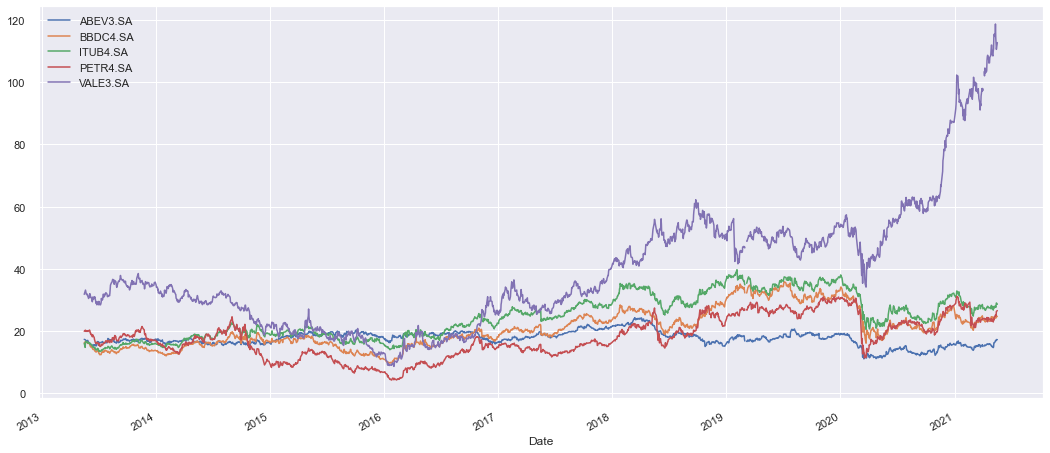

In [288]:
seaborn.set()
carteira.plot(figsize = (18,8))

A seguir, faremos um exemplo calculando o retorno e o desvio padrão desta mesma carteira. Depois, calcularemos o saldo desta carteira admitindo que um investidor comprou R$ 5.000,00 de cada uma destas ações, seguidamente iremos comparar os rendimentos dessa carteira com o ibovespa e o ibrx.

In [22]:
retorno = carteira.pct_change()
display(retorno)

retorno_acum = (retorno + 1).cumprod()
retorno_acum.iloc[0] = 1
display(retorno_acum)

,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-20,NaN,NaN,NaN,NaN,NaN
2013-05-21,-0.004773,0.005180,0.117703,0.002475,0.007905
2013-05-22,-0.008188,0.003722,0.013098,-0.016296,-0.015988
2013-05-23,-0.005425,-0.013691,-0.008419,-0.003012,-0.018700
2013-05-24,-0.005692,-0.007519,-0.003032,0.011581,-0.009684
...,...,...,...,...,...
2021-05-12,0.000000,-0.020325,-0.014653,-0.014712,-0.036978
2021-05-13,0.000593,0.023236,0.029017,0.008475,-0.016094
2021-05-14,0.017773,0.009327,0.022207,0.052421,-0.017157


,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2013-05-20,1.000000,1.000000,1.000000,1.000000,1.000000
2013-05-21,0.995227,1.005180,1.117703,1.002475,1.007905
2013-05-22,0.987078,1.008921,1.132343,0.986139,0.991791
2013-05-23,0.981723,0.995108,1.122810,0.983168,0.973244
2013-05-24,0.976135,0.987626,1.119406,0.994554,0.963819
...,...,...,...,...,...
2021-05-12,0.982046,1.462162,1.873967,1.226733,3.476133
2021-05-13,0.982628,1.496137,1.928344,1.237129,3.420189
2021-05-14,1.000092,1.510092,1.971165,1.301980,3.361508


In [37]:
''' Calculando o desvio Padrão (DP) de cada ação da carteira'''

dp = retorno.std()
print(dp)

ABEV3.SA    0.017031
BBDC4.SA    0.023474
ITUB4.SA    0.021018
PETR4.SA    0.033157
VALE3.SA    0.029206
dtype: float64


In [34]:
ex_carteira = (carteira / carteira.iloc[0]) * 5000
ex_carteira['SALDO'] = ex_carteira.sum(axis = 1)
ex_carteira = ex_carteira.loc[ex_carteira['SALDO'] > 0]
ex_carteira['RETORNO'] = ex_carteira['SALDO'].pct_change()
ex_carteira.dropna()
display(ex_carteira)
ex_ibov_ibrx = ibov_ibrx / ibov_ibrx.iloc[0] * 25000
display (ex_ibov_ibrx)

,ABEV3.SA,BBDC4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,SALDO,RETORNO
Date,,,,,,,
2013-05-20,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,25000.000000,NaN
2013-05-21,4976.135407,5025.899298,5588.517462,5012.376048,5039.526017,25642.454233,0.025698
2013-05-22,4935.390114,5044.604282,5661.714926,4930.692902,4958.954019,25531.356243,-0.004333
2013-05-23,4908.614825,4975.539681,5614.051657,4915.841550,4866.220571,25280.268284,-0.009834
2013-05-24,4880.675370,4938.129134,5597.029293,4972.772127,4819.094155,25207.700079,-0.002871
...,...,...,...,...,...,...,...
2021-05-12,4910.230891,7310.809627,9369.832844,6133.663305,17380.663416,45105.200083,-0.022749
2021-05-13,4913.141032,7480.687196,9641.718121,6185.643274,17100.942528,45322.132151,0.004809
2021-05-14,5000.460226,7550.458269,9855.827184,6509.900555,16807.540227,45724.186461,0.008871


,^BVSP,^IBX50
Date,,
2013-05-20,25000.000000,25000.000000
2013-05-21,25253.137287,25132.096936
2013-05-22,25326.744583,25063.506733
2013-05-23,25291.287410,24896.335755
2013-05-24,25316.421608,24861.595544
...,...,...
2021-05-12,53728.837902,56444.173350
2021-05-13,54175.867579,56690.687713
2021-05-14,54703.236926,57001.791726


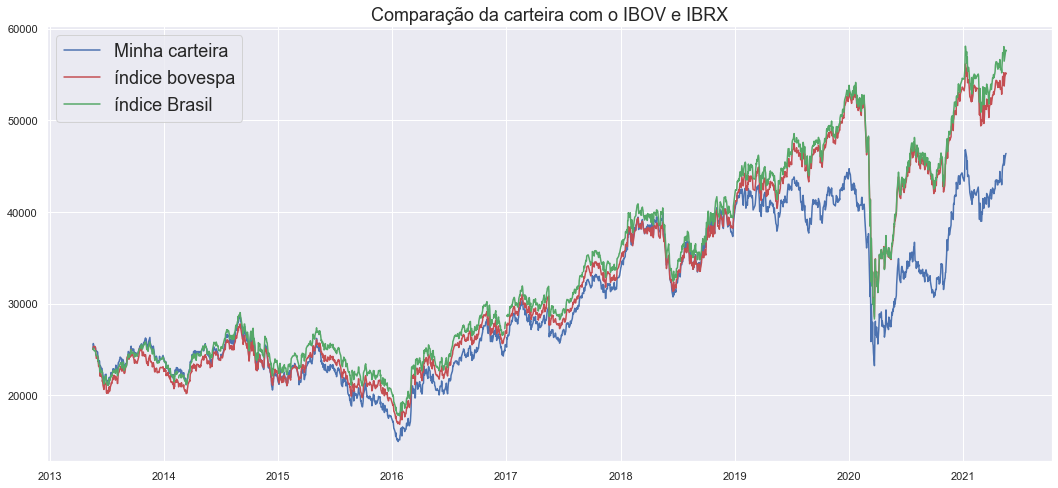

In [33]:
seaborn.set()
plt.figure(figsize = (18,8))
plt.title('Comparação da carteira com o IBOV e IBRX', fontsize = 18)
plt.plot(ex_carteira['SALDO'], label = 'Minha carteira')
plt.plot(ex_ibov_ibrx['^BVSP'], label = 'índice bovespa', color = 'r')
plt.plot(ex_ibov_ibrx['^IBX50'], label = 'índice Brasil', color = 'g')
plt.legend(fontsize = 18)
plt.show()